In this project, we'll be working with data from the CIA World Factbook, a compendium of statistics about all of the countries on Earth. In the project, we'll use SQLite to explore, analyse and visualise the data from this database.

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# Connect to the database
conn = sqlite3.connect('factbook.db')

# Activates the cursor
cursor = conn.cursor()

# SQL query to look at the tables in the database
q1 = "SELECT * FROM sqlite_master WHERE type = 'table';"

# pandas.read_sql_query() to return information on the tables in the database in DataFrame format
database = pd.read_sql_query(q1, conn)
database

,type,name,tbl_name,rootpage,sql
0,table,facts,facts,2,"CREATE TABLE ""facts"" (""id"" INTEGER PRIMARY KEY..."
1,table,sqlite_sequence,sqlite_sequence,3,"CREATE TABLE sqlite_sequence(name,seq)"


In [2]:
# Explore the data
q2 = 'SELECT * FROM facts;'

data = pd.read_sql_query(q2, conn)
data.head()

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate,created_at,updated_at
0,1,af,Afghanistan,652230.0,652230.0,0.0,32564342.0,2.32,38.57,13.89,1.51,2015-11-01 13:19:49.461734,2015-11-01 13:19:49.461734
1,2,al,Albania,28748.0,27398.0,1350.0,3029278.0,0.30,12.92,6.58,3.30,2015-11-01 13:19:54.431082,2015-11-01 13:19:54.431082
2,3,ag,Algeria,2381741.0,2381741.0,0.0,39542166.0,1.84,23.67,4.31,0.92,2015-11-01 13:19:59.961286,2015-11-01 13:19:59.961286
3,4,an,Andorra,468.0,468.0,0.0,85580.0,0.12,8.13,6.96,0.00,2015-11-01 13:20:03.659945,2015-11-01 13:20:03.659945
4,5,ao,Angola,1246700.0,1246700.0,0.0,19625353.0,2.78,38.78,11.49,0.46,2015-11-01 13:20:08.625072,2015-11-01 13:20:08.625072


Executing our previous query resulted in observing the first few rows of our facts table. The rows are representative of each country while we're able to see the column names and what they represent. 

Let's start exploring the data by calculating some summary statistics and look for any outlier countries.

In [3]:
q3 = '''
SELECT 
    MIN(population) min_pop, 
    MAX(population) max_pop, 
    MIN(population_growth) min_pop_growth, 
    MAX(population_growth) max_pop_growth 
FROM facts;
'''

pd.read_sql_query(q3, conn)

,min_pop,max_pop,min_pop_growth,max_pop_growth
0,0,7256490011,0.0,4.02


From the query we ran above we can come away with a few findings, there is a country with a population of 0 and there is a country with a population of more than 7.2 billion people. Let's investigate and see which countries are responsible for these figures.

In [4]:
q4 = '''
SELECT * FROM facts 
WHERE population = (SELECT MIN(population) FROM facts);
'''

pd.read_sql_query(q4, conn)

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate,created_at,updated_at
0,250,ay,Antarctica,None,280000,None,0,None,None,None,None,2015-11-01 13:38:44.885746,2015-11-01 13:38:44.885746


In [5]:
q5 = '''
SELECT * FROM facts 
WHERE population = (SELECT MAX(population) FROM facts);
'''

pd.read_sql_query(q5, conn)

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate,created_at,updated_at
0,261,xx,World,None,None,None,7256490011,1.08,18.6,7.8,None,2015-11-01 13:39:09.910721,2015-11-01 13:39:09.910721


From the queries we've run, we can see that the country with a population of 0 is Antartica while the entire world had a population of over 7.2 billion people. Therefore, it makes sense for us to exclude these two rows from our analysis. 



Let's move on to generating histograms for the rest of the countries in the table, ignoring these 2 rows. These histograms will be based on the columns population, population_growth, birth_rate and death_rate


Once the results table is represented as a dataframe, we can use the pd.DataFrame.hist() method to generate histograms for all of the columns.

In [6]:
q6 = '''
SELECT 
    population, 
    population_growth, 
    birth_rate, 
    death_rate 
FROM facts
WHERE population != (SELECT MIN(population) FROM facts)
AND population != (SELECT MAX(population) FROM facts);
'''

pop = pd.read_sql_query(q6, conn)
pop.head()

,population,population_growth,birth_rate,death_rate
0,32564342,2.32,38.57,13.89
1,3029278,0.30,12.92,6.58
2,39542166,1.84,23.67,4.31
3,85580,0.12,8.13,6.96
4,19625353,2.78,38.78,11.49


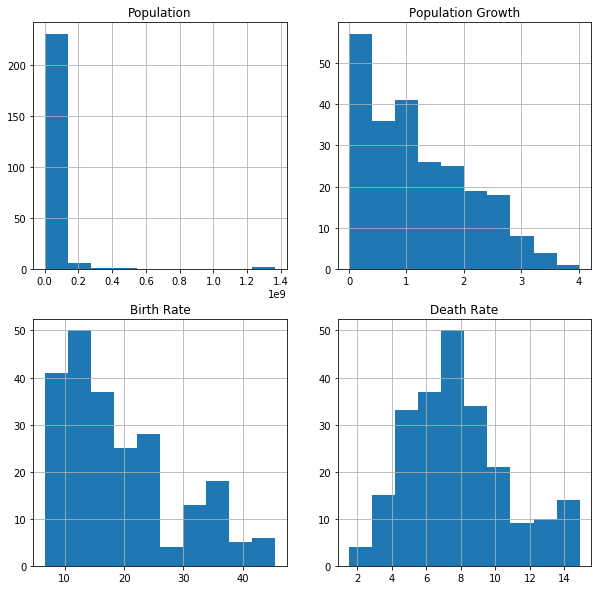

In [7]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

pop['population'].hist(ax = ax1)
ax1.set_title('Population')
pop['population_growth'].hist(ax = ax2)
ax2.set_title('Population Growth')
pop['birth_rate'].hist(ax = ax3)
ax3.set_title('Birth Rate')
pop['death_rate'].hist(ax = ax4)
ax4.set_title('Death Rate')

plt.show()

We have a right skewed distribution(positive skew) for population growth and birth rate which is understandable as the birth rate and population growth are directly related to each other. We can see there is a normal distribution for death rate while the population plot is hard to determine due to the outliers in the data. 

Next we want to determine which country has the highest population density, the ratio of population to land area.

In [8]:
q7 = '''
SELECT 
    name, 
    CAST(population as float) / CAST(area_land as folat) population_density 
FROM facts
WHERE population != (SELECT MIN(population) FROM facts)
AND population != (SELECT MAX(population) FROM facts)
ORDER BY population_density DESC;
'''

density = pd.read_sql_query(q7, conn)
density.head()

,name,population_density
0,Macau,21168.964286
1,Monaco,15267.500000
2,Singapore,8259.784571
3,Hong Kong,6655.271202
4,Gaza Strip,5191.819444


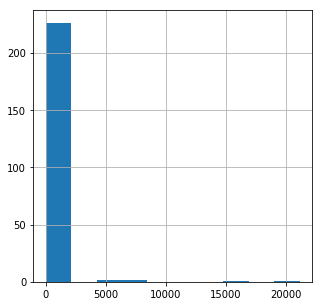

In [9]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)

density['population_density'].hist()

plt.show()

From the query we just ran we can see that Macau has the highest population density in the world. Macau is a city in China but is autonomous in a similar way to Hong Kong. The high population density may be due to the heavy tourist attraction of Macau. In a World Tourism Organization report of international tourism for 2006, Macau ranked 21st in the number of tourists and 24th in terms of tourism receipts. Because it is such a big tourist attraction, a high number of the population include non-residential workers.

We can see from the query above that there are a number of city states that dominate the population density of the world. It is understandable for these city states to have such a high population density as  there will be lots of people occupying a small land area. 

Let's now investigate which countries have the highest ratios of water to land and hhich countries have more water than land mass.

In [10]:
q8 = '''
SELECT 
    name, 
    CAST(area_water as float) / CAST(area_land as float) water_land_ratio 
FROM facts
ORDER BY water_land_ratio DESC;
'''

ratio = pd.read_sql_query(q8, conn)
ratio.head()

,name,water_land_ratio
0,British Indian Ocean Territory,905.666667
1,Virgin Islands,4.520231
2,Puerto Rico,0.554791
3,"Bahamas, The",0.386613
4,Guinea-Bissau,0.284673


We can see that the British Indian Ocean Territory has significantly more water area compared to its land mass. This territory is made up of the Chagos Archipelago with over 1,000 very small individual islands. The Virgin Islands is the only other territory to have a greater sea area compared to land mass.

In [11]:
conn.close

<function Connection.close>